In [72]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

In [3]:
data_type_list = ['source_list', 'cam_param', 'cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...


[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z...


In [12]:
subject = 'S5'
action = 'Walking 1'
cam_id = '54138969'

cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
img_2d = data['img_2d'][subject][action][cam_id].copy()
img_2d_canonical = data['img_2d_canonical_same_z'][subject][action][cam_id].copy()

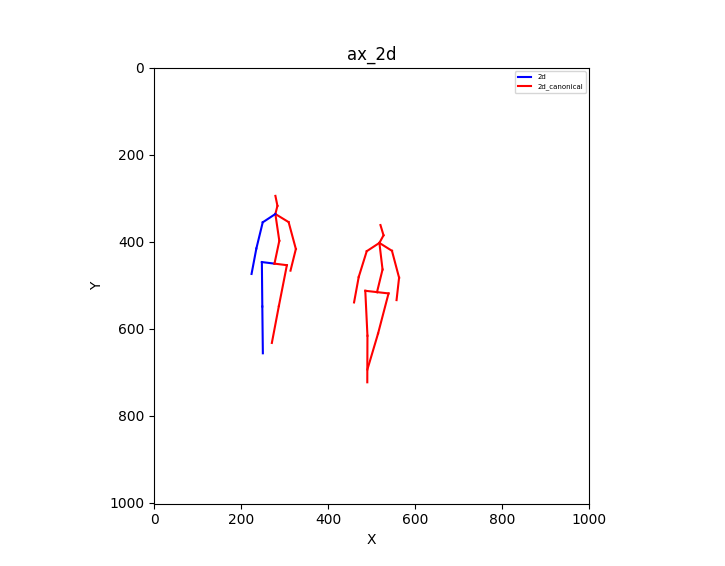

In [131]:
# check original train data
frame_num = 300
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': '2d_canonical'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### PCL

In [132]:
def generate_gt_scales_from2d(pose_2d):
    max_x = pose2d[:, 0].max()
    min_x = pose2d[:, 0].min()
    max_y = pose2d[:, 1].max()
    min_y = pose2d[:, 1].min()
    scale_x = max_x - min_x
    scale_y = max_y - min_y
    return np.array([scale_x, scale_y])

def virtualCameraRotationFromPosition(position):
    x, y, z = position[0], position[1], position[2]
    n1x = np.sqrt(1 + x ** 2)
    d1x = 1 / n1x
    d1xy = 1 / np.sqrt(1 + x ** 2 + y ** 2)
    d1xy1x = 1 / np.sqrt((1 + x ** 2 + y ** 2) * (1 + x ** 2))
    R_virt2orig = np.array([d1x, -x * y * d1xy1x, x * d1xy,
                               0*x,      n1x * d1xy, y * d1xy,
                          -x * d1x,     -y * d1xy1x, 1 * d1xy]).reshape([3, 3])
    return R_virt2orig

In [133]:
pose3d = cam_3d[frame_num].copy()
pelvis3d = pose3d[0]

K = intrinsic.copy()
hm_coord_2d = K.dot(pelvis3d)
location = hm_coord_2d/hm_coord_2d[2]

pose2d = img_2d[frame_num].copy()
pelvis2d = pose2d[0]
scale = generate_gt_scales_from2d(pose2d)

In [134]:
location, scale

(array([276.80450812, 449.96890865,   1.        ]),
 array([101.90125827, 361.89848708]))

In [135]:
pelvis2d

array([276.80450812, 449.96890865])

In [136]:
K_inv = np.linalg.inv(K)
p_position = K_inv @ location # backprojected point p
print(p_position)
R_virt2orig = virtualCameraRotationFromPosition(p_position)
R_virt2orig

[-0.20587496 -0.05725097  1.        ]


array([[ 0.97945847, -0.01128955, -0.20132969],
       [-0.        ,  0.9984315 , -0.055987  ],
       [ 0.20164597,  0.05483694,  0.97792219]])

In [137]:
p_length = np.linalg.norm(p_position)
focal_length_factor = p_length
sx = 1.0 / np.sqrt(p_position[0]**2+p_position[2]**2)  # this is cos(phi)
sy = np.sqrt(p_position[0]**2+1) / np.sqrt(p_position[0]**2+p_position[1]**2 + 1)  # this is cos(theta)
bbox_size_img = scale * np.array([sx,sy])
bbox_size_img

array([ 99.80805093, 361.33084861])

In [138]:
max_width = bbox_size_img.max()
bbox_size_img = np.array([max_width, max_width])

In [139]:
f_orig = np.array([K[0,0], K[1,1]])
f_compensated = focal_length_factor * f_orig / bbox_size_img

K_virt = np.zeros([3,3])
K_virt[2,2] = 1
# Note, in unit image coordinates ranging from 0..1
K_virt[ 0, 0] = f_compensated[0]
K_virt[ 1, 1] = f_compensated[1]
K_virt[:2, 2] = 0.5

In [140]:
K_virt_inv = np.linalg.inv(K_virt)
P_virt2orig = K @ R_virt2orig @ K_virt_inv
R_orig2virt = np.linalg.inv(R_virt2orig)
P_orig2virt = np.linalg.inv(P_virt2orig)

In [141]:
canonical_2d_pose = np.hstack([pose2d, np.ones((pose2d.shape[0], 1))])
PCL_canonical_2d_pose = (P_orig2virt @ canonical_2d_pose.T).T
virt_2d_pose = PCL_canonical_2d_pose.copy() / PCL_canonical_2d_pose[:, 2:3]
virt_2d_pose_hat = virt_2d_pose.copy() - virt_2d_pose[0]
virt_2d_pose_hat_denorm = virt_2d_pose_hat*scale[1]
virt_2d_pose_denorm = virt_2d_pose_hat_denorm + [pose2d[0,0], pose2d[0,1], 1]

In [142]:
virt_2d_pose_denorm

array([[276.80450812, 449.96890865,   1.        ],
       [248.50724616, 446.70212966,   1.        ],
       [249.35748746, 548.89790638,   1.        ],
       [250.44560359, 657.48349522,   1.        ],
       [304.90807653, 453.21332653,   1.        ],
       [286.76046624, 547.88782669,   1.        ],
       [270.82200221, 633.78860373,   1.        ],
       [287.66711265, 397.39556108,   1.        ],
       [278.79288789, 336.43441968,   1.        ],
       [283.42079348, 317.70741031,   1.        ],
       [278.87376036, 295.26247203,   1.        ],
       [308.71491179, 354.01192908,   1.        ],
       [325.36427899, 415.54162807,   1.        ],
       [313.1747022 , 465.80171853,   1.        ],
       [250.53051175, 356.16551469,   1.        ],
       [236.26586568, 416.0210131 ,   1.        ],
       [225.47431451, 474.10133243,   1.        ]])

In [143]:
# Create a batch of virt_2d_pose with batch size 1000
batch_size = img_2d.shape[0]
virt_2d_pose_denorm_batch = np.tile(virt_2d_pose_denorm, (batch_size, 1, 1))
virt_2d_pose_denorm_batch.shape

(3000, 17, 3)

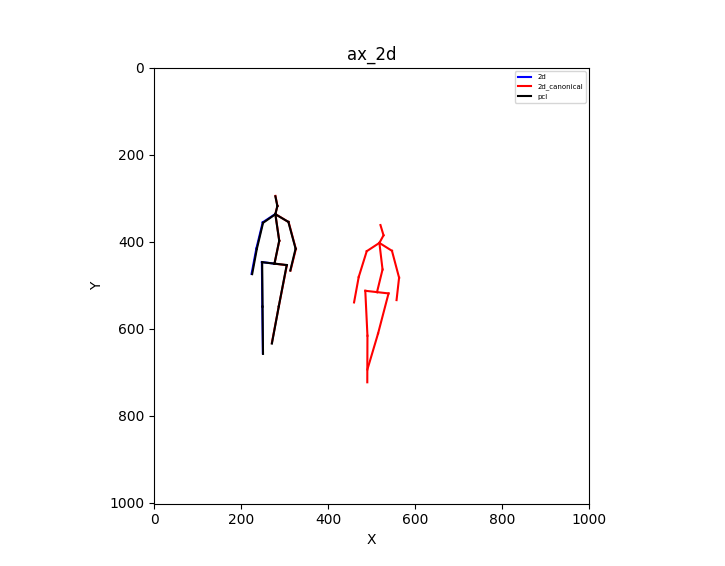

In [145]:
# check original train data
frame_num = 300
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': '2d_canonical'}),
    ('ax_2d', virt_2d_pose_denorm_batch, {'color': 'k', 'label': 'pcl'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [123]:
original_pose2d = img_2d[frame_num].copy()
canonical_pose2d = img_2d_canonical[frame_num].copy()
virt_pose2d = virt_2d_pose_denorm_batch[frame_num].copy()

original_pose2d_hat = original_pose2d - original_pose2d[0]
canonical_pose2d_hat = canonical_pose2d - canonical_pose2d[0]
virt_pose2d_hat = virt_pose2d - virt_pose2d[0]

In [125]:
original_pose2d_hat - virt_pose2d_hat[:, :2]

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 5.08945944e-01, -9.01045954e-02],
       [ 1.96727371e-01,  4.55465800e-02],
       [ 4.57442168e-02, -6.02019849e-01],
       [-2.00947708e-01,  6.12344054e-02],
       [-1.45680675e-01, -6.58002711e-01],
       [ 1.19666986e-02, -2.10780958e+00],
       [-5.76354819e-02,  2.04343266e-03],
       [ 4.67883815e-02, -3.29749221e-01],
       [ 3.88171772e-02, -4.24594247e-01],
       [ 9.51651215e-02, -6.40097350e-01],
       [-2.60407271e-01,  4.21533833e-01],
       [-1.95747762e-01,  4.50814599e-01],
       [-1.83203960e-01,  6.75160721e-02],
       [ 6.67072590e-01, -8.44244319e-01],
       [ 1.18983846e+00, -4.81859839e-01],
       [ 8.24018940e-01, -6.99378610e-02]])